### Project - Ocular Disease Recognition
The following is a detailed README file that allows the user to re-run data pre-processing, training, validation and evaluation.
I did some hyper-parameter tuning and implement several models to recognize whether the color fundus images from left and right eyes is normal or disease.
The best hyper-parameter was selected for each model, and you can reproduce the searching process and get exactly the same result as I show you.

### Install requirements

In [ ]:
! pip install -r requirements.txt

Note that as I use the pytorch framework for the project, and if you need to use GPU to accelerate the process,
you maybe need to check the corresponding torch version for your CUDA driver in the website: https://pytorch.org/get-started/previous-versions/.
For example, I used torch 1.8.1+cu111 and 0.9.1+cu111 for this project, so I can install the torch and torchvision by the following command:

In [ ]:
! pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

### Directory Structure
```
Ocular disease
-base
   |
    ----> __init__.py
    ----> base_model.py
    ----> base_trainer.py
- figs
    |
     ---> N_CGM.png
-logger
   |
    ----> __init__.py
    ----> logger.py
    ----> logger_config.json
    ----> visualization.py
-models
   |
    ----> __init__.py
    ----> pretrained_model.py
    ----> vanilla_vae.py
-saved
   |
    ----> log
          |
           ---> densenet121
                       .
                       .
                       .
           ---> vgg19_bn
    ----> models
          |
           ---> densenet121
                       .
                       .
                       .
           ---> vgg19_bn
    ----> result
          |
           --->hyper_tuning.csv
          |
           --->pretrained_model_compare.csv
-utils
   |
    ---->__init__.py
    ---->_data_loader.py
    ---->_image_process.py
    ---->_loss_helper.py
    ---->_metric.py
    ---->_parse_config.py
    ---->_plotting.py
    ---->_tools.py
    ---->_trainer.py
data_augment.py
data_preprocess.py
dataset_analysis.ipynb
dataset_split.py
experiment.ipynb
experiment.py
pretrained_model.json
README.ipynb
requirements.txt
run_model.py
train.py
```

### Data pre-processing

Before modelling data, I did some pre-processing work on the original ODIR-5K dataset.
As the author of ODIR-5K dataset provided a preprocessing_images folder, I will use that folder for training and validation.
The preprocessing_images folder only contains 6392 images, compare to the original "Training Images" folder which contains 7000 images,
it removes some low quality images, crop and resize all images to 512*512. For details about dataset analysis, check jupyter notebook [dataset_analysis](dataset_analysis.ipynb).

In [1]:
# run data pre-process on Testing Images by default with crop tasks
! python data_preprocess.py

The flag used in data_preprocess script includes:
- -s: source path, by default is "dataset/ODIR-5K/ODIR-5K/Testing Images"
- -d: destination path, by default is "dataset/test_crop"
- -w: width of image after resizing, by default is 512, get 512*512 square images.
- -t: specify the task from "crop" and "resize"
- -q: quality of images, by default is 100
- -k: whether keep aspect ratio, by default is false.

You can check the pre-process [log](saved/log/data_process.log) under directory saved/log, with filename is data_process.log

In [4]:
# resize and flip test images
! python data_preprocess.py -s dataset/test_crop -d dataset/test_512 -t resize

In [1]:
# resize and flip  train images
! python data_preprocess.py -s dataset/preprocessed_images -d dataset/train_512 -w 512 -t resize

### Dataset split
The preprocessed image's dataset are divided into train, valid, and test set according to the number of each class with a pre-defined ratio.
I tried to find the labels of "ODIR-5K Testing Images", but I did not find it, so I can not use it to evaluate my models.
That is why I split another test set for this task.
Run the dataset_split.py script, it will return the csv file of each partition.
The flag used in the dataset_split.py includes:

- -f: the path of full_df.csv, default is "dataset/full_df.csv"
- -v: the ratio of validation set, default is 0.15
- -t: the ratio of test set, default is 0.15
- -s: the saved directory of produced csv file(train_df.csv, valid_df.csv, test_df.csv), default is "dataset/"

In [8]:
# run dataset_split.py script
! python dataset_split.py -v 0.1 -t 0.1

Training set info:
 Count: 5114, positive label(N): 2299, negative label(not N): 2815
Validation set info:
 Count: 639, positive label(N): 287, negative label(not N): 352
Test set info:
 Count: 639, positive label(N): 287, negative label(not N): 352


This will generate three files under saved directory(-s): train_df.csv, valid_df.csv, test_df.csv
#### Data augmentation
The Training set is not balanced, the number of negative label(2463) is higher than the number of positive label(2011).
So we need to take some measures to balance the set. The most popular strategies include down-sampling and up-sampling.
Therefore, some image augmentation strategies are applied to argument dataset through script data_argument.py with flags:
- -t: the path to train_df.csv, default is dataset/train_df.csv
- -s: the path to new saved train_df_aug.csv, default is dataset/train_df_aug.csv
- -r: the path to root dataset, default is dataset/train_512
- -a: the path to augment dataset, default is dataset/train_aug

In [ ]:
! python data_augment.py

### Experiment
As the main part of the dataset is image data, I consider to start with a series of CNN models with pretrained weight in torchvision models library.
There are many CNN models pre-defined in pytorch, and you can find a list [here](https://pytorch.org/vision/stable/models.html#classification).
For these pretrained model, I defined a configuration file named [pretrained_model.json](pretrained_model.json).
For evaluation methods, I recorded loss of training and validation sets and calculated AUC(area under curve) and Accuracy for comparison.

#### Pretrained model fine-tuning
The most popular CNN model family is ResNet, VGG, and DenseNet, so for the rest of experiments, I will focus on them.
And they all have some variant models, it will take hours to train these models even with GPU resources.
Therefore, I firstly start with a relative small model named GoogLeNet to find the best hyper-parameter that is not tightly related with specific model.
Such as image size, batch size and learning rate, in order to save time, I will not use grid search.
Instead, each time when a group of hyper-parameters is tested, the best one will apply to the next group directly.

To train a single pretrained model, run the script train.py with flags:
- -c: config file, the configuration of model.
- -r: resume from saved checkpoint
- -d: indices of GPUs to enable(default use all)
- -m: specify the pretrained model (such as: resnet50)
- -f: whether freeze the pretrained model, default is 1 (freeze parameters)
- --bs: batch size
- --lr: learning rate

In [ ]:
# An example to run model
! python train.py -c pretrained_model.json -m resnet34


In order to reproduce the experiment, you can check and run in experiment.ipynb. Or excute the following command.

In [ ]:
! python experiment.py

In [12]:
# run the tensorboard to check the log of training loss and validation loss.
# maybe you need to run this in terminal.
! tensorboard --logdir saved/log

^C


In [1]:
import base64
f = open("figs/vgg11_bn_loss.png", "rb") 
# save to base64 code
ls_f = base64.b64encode(f.read()) 
f.close()
print(ls_f)

b'iVBORw0KGgoAAAANSUhEUgAAA4QAAAFqCAYAAABCn5TgAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAN7HSURBVHhe7P3psxzXdSWOvn/FHxzh6Ph9cPh1OLrdsqTnn9SS25LbsmRbtETbsixalkzKFCWRFEVxpjjP80yCIAlQAAkSIAFinoh5nmcQ84wL4AIEQIDn5TqVO2vlrp01V92qW3tFrKjMs8+wz8k8uWvl+P8JDofD4XA4HA6Hw+EYSLggdDgcDofD4XA4HI4BhQtCh8PhcDgcDofD4RhQuCB0OBwOh8PhcDgcjgGFC0KHw+FwOBwOh8PhGFC4IHQ4HA6Hw+FwOByOAYULQofD4XA4HA6Hw+EYULggdDgcDofD4XA4HI4BhQtCh8PhcDgcDofD4RhQuCB0OBwOh8PhcDgcjgGFC0KHw+FwOBwOh8PhGFC4IHQ4HA6Hw+FwOByOAYULQofD4XA4auDQoUPhqaeeCsuWLUtT6sPFixfD22+/HYllh8PhcDh6DT0pCPfs2RO++c1vhrFjx6YpDofD4XCMHLZt2xa+8IUvhPHjx8f1CxcuhFtuuSVcc8014ezZszHNwrlz58LPfvazSCw7HA6Hw9FraIsgXLVqVfibv/mb+NsOQBD+4Ac/CO+9916a4nA4HA7HyMEShL/73e/CbbfdVlXouSB0OBwOR6+jLYJw8eLF4Q/+4A/ir8PhcDgcow1aENYLF4QOh8Ph6HW0JAjlmYpf/vKXURDi98UXXwzDw8Nhx44d4eGHHw5btmwJs2fPjstIA3B7zbvvvhvTQNhxtlWgn9VAfah36tSp4cSJE+H111+P5V566aVw9OjRmMfhcDgcDsZnn30WJk6cGEUcxxgA8eXpp58OR44cieu14pIWhEXPBnI9L7zwQti6dasLQofD4XD0NFoShLt37w7//M//HL7yla9EQYjfq6++Opw8eT

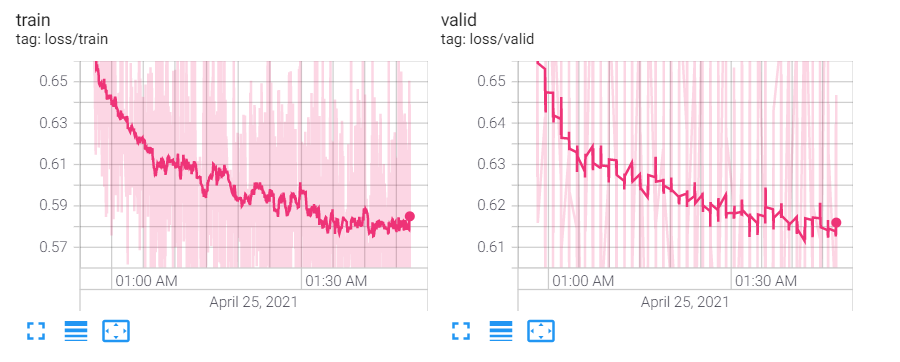

In [8]:
import pandas as pd
# I have included the result csv file, it can reproduced in experiment notebook
hyper_tuning_df = pd.read_csv("saved/result/hyper_tuning.csv")
hyper_tuning_df

,model,val_auc,val_acc,test_auc,test_acc,hyper_parameters,parameters,FLOPS,Time Consuming
0,GoogLeNet,0.6749,0.6322,0.6714,0.6338,128_32_0.001,6.753M,15.751G,3.4 s
1,GoogLeNet,0.7315,0.6573,0.7588,0.7011,256_16_0.001,6.753M,31.446G,4.58 s
2,GoogLeNet,0.7291,0.6651,0.7314,0.6729,256_32_0.001,6.753M,62.892G,4.5 s
3,GoogLeNet,0.7500,0.7027,0.7499,0.6823,256_64_0.0001,6.753M,125.784G,4.45 s
4,GoogLeNet,0.7363,0.6761,0.7356,0.6729,256_64_0.001,6.753M,125.784G,4.51 s
5,GoogLeNet,0.6447,0.5947,0.6294,0.5900,256_64_0.01,6.753M,125.784G,4.43 s
6,GoogLeNet,0.7373,0.6541,0.7417,0.6714,512_32_0.001,6.753M,251.457G,9.91 s


In [9]:
print(hyper_tuning_df.to_latex(index=False))

\begin{tabular}{lrrrrllll}
\toprule
    model &  val\_auc &  val\_acc &  test\_auc &  test\_acc & hyper\_parameters & parameters &    FLOPS & Time Consuming \\
\midrule
GoogLeNet &   0.6749 &   0.6322 &    0.6714 &    0.6338 &     128\_32\_0.001 &     6.753M &  15.751G &          3.4 s \\
GoogLeNet &   0.7315 &   0.6573 &    0.7588 &    0.7011 &     256\_16\_0.001 &     6.753M &  31.446G &         4.58 s \\
GoogLeNet &   0.7291 &   0.6651 &    0.7314 &    0.6729 &     256\_32\_0.001 &     6.753M &  62.892G &          4.5 s \\
GoogLeNet &   0.7500 &   0.7027 &    0.7499 &    0.6823 &    256\_64\_0.0001 &     6.753M & 125.784G &         4.45 s \\
GoogLeNet &   0.7363 &   0.6761 &    0.7356 &    0.6729 &     256\_64\_0.001 &     6.753M & 125.784G &         4.51 s \\
GoogLeNet &   0.6447 &   0.5947 &    0.6294 &    0.5900 &      256\_64\_0.01 &     6.753M & 125.784G &         4.43 s \\
GoogLeNet &   0.7373 &   0.6541 &    0.7417 &    0.6714 &     512\_32\_0.001 &     6.753M & 251.457G &   

As presented in the above table, the accuracy and AUC of the model increase with the increase of the image size,
while the running speed (measured by FLOPS) gradually slows down.
The memory usage of the model is directly proportional to the batch size and image size,
and the batch size has a relatively small impact on the performance of the model.
Therefore, when the GPU memory is insufficient, the problem is mainly solved by reducing the batch size.
The setup of learning rate affects the performance a lot, and a relatively small learning rate can improve the performance of models.


In [6]:
pretrained_results = pd.read_csv("saved/result/pretrained_model_compare.csv")
pretrained_results

,model,val_auc,val_acc,test_auc,test_acc,parameters,FLOPS,Time Consuming
0,resnet34,0.7330,0.6635,0.7795,0.7089,21.926M,153.443G,5.42s
1,resnet50,0.7165,0.6541,0.7639,0.6854,25.685M,171.829G,5.59s
2,resnet101,0.7441,0.6557,0.7645,0.6948,44.678M,327.412G,7.02s
3,resnet152,0.7357,0.6573,0.7619,0.7027,60.321M,483.096G,8.71s
4,vgg11_bn,0.7389,0.6635,0.7554,0.6839,132.997M,317.755G,5.85s
5,vgg13_bn,0.7280,0.6510,0.7524,0.6776,133.182M,472.977G,7.4s
6,vgg16_bn,0.7265,0.6588,0.7732,0.7089,138.494M,647.087G,8.0s
7,vgg19_bn,0.7179,0.6322,0.7520,0.6792,143.807M,821.197G,8.49s
8,densenet121,0.7419,0.6604,0.7647,0.6870,8.107M,119.767G,6.26s
9,densenet169,0.7683,0.6980,0.7760,0.7074,14.278M,142.013G,6.8s


In [7]:
print(pretrained_results.to_latex(index=False))


\begin{tabular}{lrrrrlll}
\toprule
      model &  val\_auc &  val\_acc &  test\_auc &  test\_acc & parameters &    FLOPS & Time Consuming \\
\midrule
   resnet34 &   0.7330 &   0.6635 &    0.7795 &    0.7089 &    21.926M & 153.443G &          5.42s \\
   resnet50 &   0.7165 &   0.6541 &    0.7639 &    0.6854 &    25.685M & 171.829G &          5.59s \\
  resnet101 &   0.7441 &   0.6557 &    0.7645 &    0.6948 &    44.678M & 327.412G &          7.02s \\
  resnet152 &   0.7357 &   0.6573 &    0.7619 &    0.7027 &    60.321M & 483.096G &          8.71s \\
   vgg11\_bn &   0.7389 &   0.6635 &    0.7554 &    0.6839 &   132.997M & 317.755G &          5.85s \\
   vgg13\_bn &   0.7280 &   0.6510 &    0.7524 &    0.6776 &   133.182M & 472.977G &           7.4s \\
   vgg16\_bn &   0.7265 &   0.6588 &    0.7732 &    0.7089 &   138.494M & 647.087G &           8.0s \\
   vgg19\_bn &   0.7179 &   0.6322 &    0.7520 &    0.6792 &   143.807M & 821.197G &          8.49s \\
densenet121 &   0.7419 &   0.6

The performance of these three models is very similar.
In general, for a deep structure model, the more deep network layers the model has, the more parameters and GPU resources are occupied, and the more time is consumed.
But from the ACC and AUC results in Table above, a deeper model does not necessarily perform better.
Therefore, the choice of a model needs to be considered based on the actual situation.
For example, when a fast response is required, the faster running model should be prioritized, such as ResNet34,
and when the memory resources are not so sufficient, DenseNet121 may be a considerable one.